Let's start by some imports: stats and basic numerical operations.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import preprocessing 
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree
import seaborn as sb

The data lives into one big csv file. Let's read that in a pandas data frame:

In [2]:
file_data = 'data_files/HNU1_Csub.csv'
data = pd.read_csv(file_data)
data

,network,pair,correlation,days_apart,site_label,site_label_concat,exact_site_label1,exact_site_label2,scanner1,scanner2,scanner_Label,visit1,subject1,visit2,subject2,id1,id2
0,DMN,s0025427-0 vs s0025427-1,0.777,3.0,Hnu,HnuHnu,Hnu0,Hnu1,GE,GE,GEGE,1,s0025427,2,s0025427,s0025427-0,s0025427-1
1,DMN,s0025427-0 vs s0025427-2,0.697,6.0,Hnu,HnuHnu,Hnu0,Hnu2,GE,GE,GEGE,1,s0025427,3,s0025427,s0025427-0,s0025427-2
2,DMN,s0025427-0 vs s0025427-3,0.805,9.0,Hnu,HnuHnu,Hnu0,Hnu3,GE,GE,GEGE,1,s0025427,4,s0025427,s0025427-0,s0025427-3
3,DMN,s0025427-0 vs s0025427-4,0.802,12.0,Hnu,HnuHnu,Hnu0,Hnu4,GE,GE,GEGE,1,s0025427,5,s0025427,s0025427-0,s0025427-4
4,DMN,s0025427-0 vs s0025427-5,0.764,15.0,Hnu,HnuHnu,Hnu0,Hnu5,GE,GE,GEGE,1,s0025427,6,s0025427,s0025427-0,s0025427-5
5,DMN,s0025427-0 vs s0025427-6,0.776,18.0,Hnu,HnuHnu,Hnu0,Hnu6,GE,GE,GEGE,1,s0025427,7,s0025427,s0025427-0,s0025427-6
6,DMN,s0025427-0 vs s0025427-7,0.655,21.0,Hnu,HnuHnu,Hnu0,Hnu7,GE,GE,GEGE,1,s0025427,8,s0025427,s0025427-0,s0025427-7
7,DMN,s0025427-0 vs s0025427-8,0.705,24.0,Hnu,HnuHnu,Hnu0,Hnu8,GE,GE,GEGE,1,s0025427,9,s0025427,s0025427-0,s0025427-8
8,DMN,s0025427-0 vs s0025427-9,0.804,27.0,Hnu,HnuHnu,Hnu0,Hnu9,GE,GE,GEGE,1,s0025427,10,s0025427,s0025427-0,s0025427-9
9,DMN,s0025427-0 vs s0025428-0,0.546,0.0,Hnu,HnuHnu,Hnu0,Hnu0,GE,GE,GEGE,1,s0025427,1,s0025428,s0025427-0,s0025428-0


# List of relevant variables (scan, site, scanner, network)
Let's extract the labels of the network, the ID for each scan, as well as a list of sites:

In [3]:
list_subject = np.unique([data.subject1.values.flatten() , data.subject2.values.flatten()])
list_id = np.unique([data.id1.values.flatten() , data.id2.values.flatten()])
list_net = np.unique(data.network.values.flatten())
print('Number of subjects: %i \nNumber of networks: %i\nNumber of scans: %i' 
      % (list_subject.size , list_net.size , list_id.size))

Number of subjects: 27 
Number of networks: 7
Number of scans: 284


In [4]:
np.sum(data.network=='MOT')

40186

In [5]:
284*283/2

40186.0

# encode within-site, between-site within-scanner, and between-scanner comparisons
Let's start by within-site comparisons. For those, `site_label_concat` is going to be the same as `site_label`, repeated twice.

In [6]:
mask_within_site = data.site_label_concat == data.site_label+data.site_label

For the within-scanner, between-site, it's easy. We just compare `scanner1` and `scanner2`, and make sure it's not a within-site comparison.

In [7]:
mask_within_scanner = (data.scanner1 == data.scanner2) & ~mask_within_site


Finally, for the between-scanner, we just make sure that `scanner1` is different from `scanner2`.

In [8]:
mask_between_scanner = data.scanner1 != data.scanner2

# Building similarity matrix
## Spatial similarity
Now, we are going to build the whole matrix of inter-scan comparisons for each network:

In [9]:
all_comp = {}
all_subj = {}
for net in list_net:
    print("%s" % net)
    all_comp[net] = np.zeros([list_id.size,list_id.size])
    all_subj[net] = np.zeros([list_id.size,list_id.size])
    all_mask = {'within_site': np.zeros([list_id.size,list_id.size]),
                'within_scanner': np.zeros([list_id.size,list_id.size]),
                'between_scanner': np.zeros([list_id.size,list_id.size])}
    flat_comp = data[:][data.network==net]
    flat_comp.index = range(flat_comp.shape[0])
    for ll in range(flat_comp.shape[0]):
        # find the linear index corresponding to each exam ID
        ind1 = np.where(list_id==flat_comp.id1[ll])
        ind2 = np.where(list_id==flat_comp.id2[ll])
        # Simply copy over the inter-scan consistency measures in matrix form
        all_comp[net][ind1,ind2] = flat_comp.correlation[ll]
        all_comp[net][ind2,ind1] = all_comp[net][ind1,ind2]
        # copy the values of the site and scanner masks
        all_mask['within_site'][ind1,ind2] = mask_within_site[ll]
        all_mask['within_site'][ind2,ind1] = all_mask['within_site'][ind1,ind2]
        all_mask['within_scanner'][ind1,ind2] = mask_within_scanner[ll]
        all_mask['within_scanner'][ind2,ind1] = all_mask['within_scanner'][ind1,ind2]
        all_mask['between_scanner'][ind1,ind2] = mask_between_scanner[ll]
        all_mask['between_scanner'][ind2,ind1] = all_mask['between_scanner'][ind1,ind2]
        
        # Extract subject IDs
        subject1 = flat_comp.subject1[ll]
        subject2 = flat_comp.subject2[ll]
        # Now encode the intra- inter- subject comparisons
        ind_subj = np.where(list_subject==subject1)
        if subject1 == subject2:
            # encode intra-subject comparisons for subject I with I+1 (use 1-indexing)
            all_subj[net][ind2,ind1] = ind_subj[0][0]+1
        else:
            if (subject1 == 'Csub') or (subject2 == 'Csub'):
                # Encode comparisons of Csub with HNU1 using -1
                all_subj[net][ind2,ind1] = -1
            else:
                # Encode inter-subject HNU1 comparisons with 0
                all_subj[net][ind2,ind1] = 0
        all_subj[net][ind1,ind2] = all_subj[net][ind2,ind1]

CER
DMN
FPN
LIM
MOT
SAL
VIS


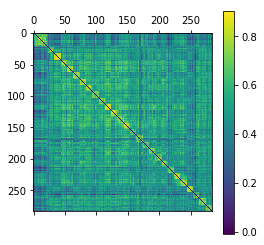

In [10]:
plt.matshow(all_comp['MOT'])
plt.colorbar()

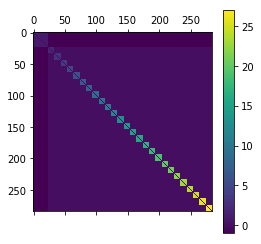

In [11]:
plt.matshow(all_subj['MOT'])
plt.colorbar()

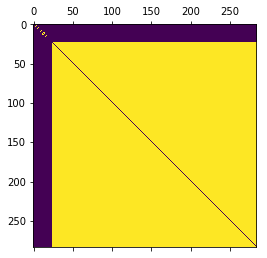

In [12]:
plt.matshow(all_mask['within_site'])

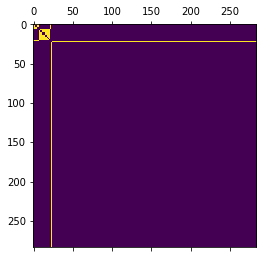

In [13]:
plt.matshow(all_mask['within_scanner'])

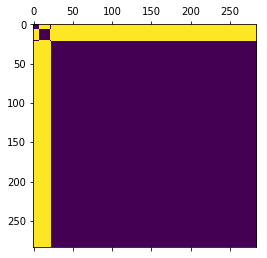

In [14]:
plt.matshow(all_mask['between_scanner'])

In [15]:
for net in list_net:
    print("\n*******************\n", 
           net, "\n",)
    print("inter-subject consistency (HNU1):", np.mean(all_comp[net][all_subj[net]==0]),
          "  (std ", np.std(all_comp[net][all_subj[net]==0]),")")
    print("consistency Csub vs HNU1:", np.mean(all_comp[net][all_subj[net]==-1]),
          "  (std ", np.std(all_comp[net][all_subj[net]==-1]),")")
    print("Mean consistency HNU1:", np.mean(all_comp[net][all_subj[net]>1]),          
         "   (std ", np.std(all_comp[net][all_subj[net]>0]), ")")
    print("consistency Csub:", np.mean(all_comp[net][all_subj[net]==1]),
          "   (std ", np.std(all_comp[net][all_subj[net] == 1]), ")")


*******************
 CER 

inter-subject consistency (HNU1): 0.4200648244592856   (std  0.08040664236550495 )
consistency Csub vs HNU1: 0.3710689102564102   (std  0.0742689891635571 )
Mean consistency HNU1: 0.6428991452991453    (std  0.09881682264035262 )
consistency Csub: 0.5906557971014493    (std  0.09057802107120812 )

*******************
 DMN 

inter-subject consistency (HNU1): 0.4772621775626493   (std  0.10461854353264562 )
consistency Csub vs HNU1: 0.3340567307692308   (std  0.07006468613473041 )
Mean consistency HNU1: 0.7325692307692308    (std  0.12653795436979165 )
consistency Csub: 0.5627644927536231    (std  0.100162290266394 )

*******************
 FPN 

inter-subject consistency (HNU1): 0.3862384045095276   (std  0.0869306752849606 )
consistency Csub vs HNU1: 0.26225817307692306   (std  0.08743092794180396 )
Mean consistency HNU1: 0.6785358974358974    (std  0.11711191079806983 )
consistency Csub: 0.5291086956521739    (std  0.10736185493647232 )

*******************
 

## Implement a regression model for intra- vs inter- subject variations

The intra-subject comparison for HNU1:

Size of X_intra:  (40186, 27)


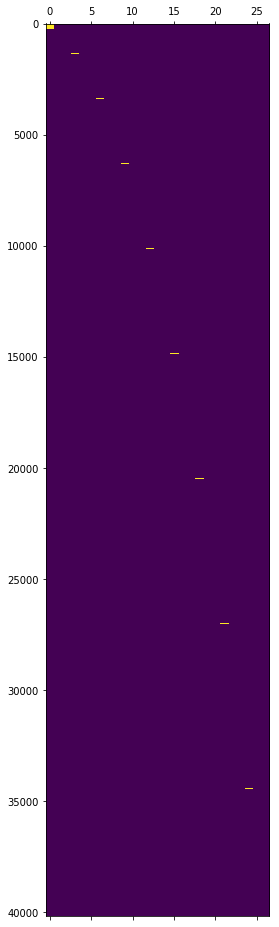

In [16]:
il = np.tril_indices(all_comp['MOT'].shape[0],-1)
all_subj_vec = all_subj['MOT'][il]
X_intra = np.zeros([ all_subj_vec.shape[0], np.int(np.max(all_subj_vec))])
for sub in range(0,X_intra.shape[1]):
    X_intra[:,sub] = all_subj_vec == (sub+1)
plt.matshow(X_intra, aspect='auto')
print("Size of X_intra: ",X_intra.shape)

The inter-subject comparisons (just for HNU1, and then HNU1 vs Csub):

Size of X_inter:  (40186, 27)


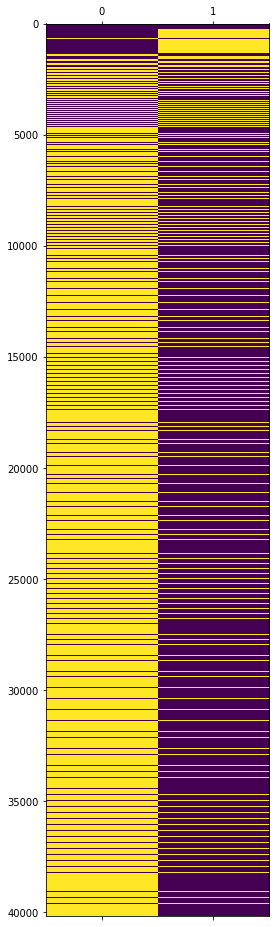

In [17]:
X_inter = np.zeros([ all_subj_vec.shape[0], 2])
X_inter[:,0] = all_subj_vec == 0
X_inter[:,1] = all_subj_vec == -1

plt.matshow(X_inter, aspect='auto')
print("Size of X_inter: ",X_intra.shape)

## Assembling the full model and running the GLM

In [18]:
X = np.concatenate([X_intra , X_inter], axis=1)
labels = np.concatenate([['intra_csub'], 
                         ["intra_hnu1" + str(sub) for sub in range(0,26)], 
                         ['inter_csub_hnu1', 'inter_hnu1']])

List of contrasts:

In [19]:
list_contrast = ['intra_csub_vs_intra_hnu1' , 
                 'inter_csub_hnu1_vs_inter_hnu1', 
                 'intra_hnu1_vs_inter_hnu1' , 
                 'intra_csub_vs_inter_hnu1']

contrast = dict(zip(list_contrast,[np.zeros([1,29]) for ii in range(0,4)]))

contrast['intra_csub_vs_intra_hnu1'][0][0] = 1
contrast['intra_csub_vs_intra_hnu1'][0][1:27] = -np.ones([1,26])/26

contrast['inter_csub_hnu1_vs_inter_hnu1'][0][27] = 1
contrast['inter_csub_hnu1_vs_inter_hnu1'][0][28] = -1

contrast['intra_hnu1_vs_inter_hnu1'][0][1:27] = np.ones([1,26])/26
contrast['intra_hnu1_vs_inter_hnu1'][0][28] = -1

contrast['intra_csub_vs_inter_hnu1'][0][0] = 1
contrast['intra_csub_vs_inter_hnu1'][0][28] = -1

In [20]:
for net in list_net:
    Y = all_comp[net][il]
    results = sm.OLS(Y, X).fit()
    print("Network: ", net)
    for cname in list_contrast:
        test = results.t_test(contrast[cname])
        print("Contrast: ", cname, 
          "; p-value: ", test.pvalue,
          "; t-test:", test.tvalue[0][0])

Network:  CER
Contrast:  intra_csub_vs_intra_hnu1 ; p-value:  6.6278875834984045e-25 ; t-test: -10.312767413328704
Contrast:  inter_csub_hnu1_vs_inter_hnu1 ; p-value:  0.0 ; t-test: 48.58095637137035
Contrast:  intra_hnu1_vs_inter_hnu1 ; p-value:  0.0 ; t-test: 112.70800889938565
Contrast:  intra_csub_vs_inter_hnu1 ; p-value:  0.0 ; t-test: 47.1567205341363
Network:  DMN
Contrast:  intra_csub_vs_intra_hnu1 ; p-value:  2.3875061452812613e-153 ; t-test: -26.493842282952972
Contrast:  inter_csub_hnu1_vs_inter_hnu1 ; p-value:  0.0 ; t-test: 109.75488181429589
Contrast:  intra_hnu1_vs_inter_hnu1 ; p-value:  0.0 ; t-test: 130.60201790002466
Contrast:  intra_csub_vs_inter_hnu1 ; p-value:  0.0 ; t-test: 38.82120568644134
Network:  FPN
Contrast:  intra_csub_vs_intra_hnu1 ; p-value:  1.600787469536994e-153 ; t-test: -26.50916852816537
Contrast:  inter_csub_hnu1_vs_inter_hnu1 ; p-value:  0.0 ; t-test: 107.93971894408972
Contrast:  intra_hnu1_vs_inter_hnu1 ; p-value:  0.0 ; t-test: 155.11807636122

# Fingerprinting stats

In [21]:
def dice(list_subject,part2):
    d = 2*np.sum((part1==1)&(part2==1))/(np.sum(part1)+np.sum(part2))
    return d

In [22]:
def sample_time(subj, list_id, all_mask, type='all'):
    mask = np.zeros(list_id.shape)
    for ll in range(len(list_id)): mask[ll] = subj in list_id[ll] 
    if np.any(mask):
        ind = np.where(mask)[0]
        ind = ind[np.random.permutation(len(ind))]
        list_time = list(list_id[(ind[0:2])])
    else:    
        for ll in range(len(list_id)): mask[ll] = "s00" not in list_id[ll]  
        ind = np.where(mask)[0]
        mask2 = 0
        while not np.any(mask2):
            ind = ind[np.random.permutation(len(ind))]
            if type == 'all':
                mask2 = mask
            else: 
                mask2 = all_mask[type][ind[0],:] * mask
        ind2 = np.where(mask2)[0]
        ind2 = ind2[np.random.permutation(len(ind2))]
        list_time = list(list_id[[ind[0],ind2[0]]])
    return list_time

In [23]:
part_ref = np.repeat(range(list_subject.size),2)

In [24]:
n_samp = 10000
n_time = 2
list_simus = ['within_site', 'within_scanner', 'between_scanner']
succ = {}

for type_simu in list_simus:
    nn = 0
    succ[type_simu] = np.zeros([n_samp,list_subject.size,list_net.size])
    for net in list_net:
        print("%s" % net)
        for ss in range(n_samp):
            list_time = []
            for subj in list_subject:
                list_time = list_time + sample_time(subj, list_id, all_mask, type_simu)
            comp_samp = all_comp[net][np.isin(list_id,list_time),:][:,np.isin(list_id,list_time)]
            iu = np.triu_indices(comp_samp.shape[0],1)
            dist_part = 2-comp_samp[iu]
            hier = linkage(dist_part, method="ward") # scipy's hierarchical clustering
            part = np.squeeze(cut_tree(hier,n_clusters=list_subject.size))
            for ssub in range(list_subject.size):
                succ[type_simu][ss,ssub,nn] = float(part[2*ssub] == part[1+2*ssub]) * float(np.sum(part == part[2*ssub]) == 2)
        nn += 1
    succ[type_simu] = np.mean(succ[type_simu],axis=0)

CER
DMN
FPN
LIM
MOT
SAL
VIS
CER
DMN
FPN
LIM
MOT
SAL
VIS
CER
DMN
FPN
LIM
MOT
SAL
VIS


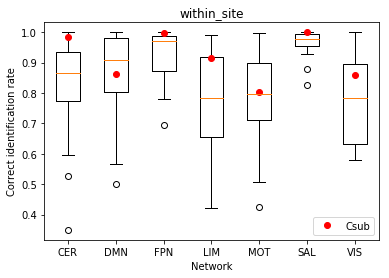

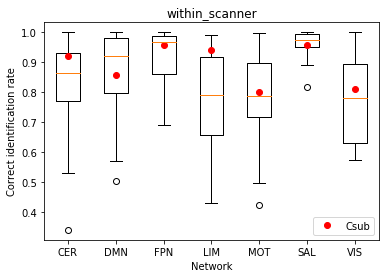

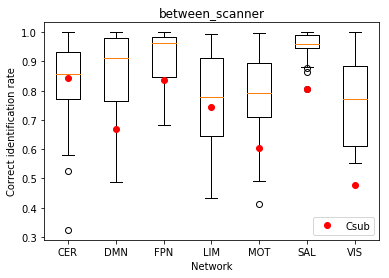

In [25]:
for type_simu in list_simus:
    plt.figure()
    ax = plt.boxplot(succ[type_simu][1:,:])
    plt.plot(range(1,list_net.size+1),succ[type_simu][0,:],color='red',marker='o',linestyle='none',label='Csub')
    plt.legend()
    plt.xlabel("Network")
    plt.ylabel("Correct identification rate")
    plt.title(type_simu)
    loc, labels = plt.xticks(range(1,list_net.size+1),list_net)